In [1]:
#this program will do the photometry on the reference frame to get stars 
#for the subtraction and to get stars for later

#if you use this code, please cite Oelkers & Stassun 2018

#import the relevant libraries for basic tools
import numpy as np
import scipy
from scipy import stats
import scipy.ndimage as ndimage
import astropy
from astropy.stats import sigma_clipped_stats
import math
import time
from photutils import DAOStarFinder
from photutils import aperture_photometry
from photutils import CircularAperture
from photutils import CircularAnnulus

#for reading in fits files
from astropy.io import fits
from astropy.wcs import WCS

#import relevant libraries for a list
import glob, os
from os import listdir
from os.path import isfile, join, exists
%matplotlib inline                           
%config InlineBackend.figure_format='retina'      
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pylab as plt                     
plt.rcParams['figure.figsize'] = (14.0, 14.0)    

In [2]:
def coord_min(x,y,xs,ys):
    array=[]
    dif=[]
    closest=[]
    sigmax = np.std(xs)
    sigmay = np.std(ys)
    for i in range(len(xs)):
        if abs(x - xs[i])<sigmax/50 and abs(y - ys[i])<sigmay/50:
            #array.append([xs[i],ys[i]])
            dif.append(np.sqrt((x - xs[i])**2+(y - ys[i])**2))
            if np.min(dif) == np.sqrt((x - xs[i])**2+(y - ys[i])**2):
                closest.append([xs[i],ys[i]])
    return closest[-1]

## Here I only study one skygroup

In [8]:
###BEGIN UPDATE#####
skygroup = 1
#useful directories
cdedir = '/home/usuario/dia_kepler/mychanges/Python/' #code directory
caldir = '/home/usuario/Documents/Mestrado/FFIs/testeall/clean/masters/season0/' # directory to output the flux files and location of master frame
clndir = '/home/usuario/Documents/Mestrado/FFIs/testeall/clean/'#directory with the cleaned images
##END UPDATE####

#read in the master frame
mast, mheader = fits.getdata(caldir+'new'+'{:02d}'.format(skygroup)+'.fits', header = True)

In [9]:
# import pandas as pd
# file = "/home/usuario/Documents/Mestrado/FFIs/allffi_cut/clean/masters/kic_ct_join_12142009.txt"
# kic = pd.read_csv(file,sep='|',header=[0])

In [10]:
# kic2 = kic.loc[:,['kic_kepler_id','kic_ra','kic_degree_ra','kic_dec','kic_kepmag','kct_sky_group_id_value','kct_num_season_onCCD','kic_variable','kic_umag', 'kic_gmag', 'kic_rmag', 'kic_imag', 'kic_zmag','kic_gredmag','kic_d51mag', 'kic_jmag', 'kic_hmag', 'kic_kmag']]
# kic2 = kic.loc[:,['kic_kepler_id','kic_ra','kic_degree_ra','kic_dec','kic_kepmag','kct_sky_group_id_value','kct_num_season_onCCD','kic_variable','kic_galaxy','kct_module_season_0_value','kct_module_season_1_value','kct_module_season_2_value','kct_module_season_3_value','kct_output_season_0_value','kct_output_season_1_value', 'kct_output_season_2_value','kct_output_season_3_value']]
# kic2.to_csv("/home/usuario/Documents/Mestrado/FFIs/allffi_cut/clean/masters/kic_cut.csv")

In [11]:
'''kic.columns = 'kic_kepler_id', 'kic_ra', 'kic_dec', 'kic_pmra', 'kic_pmdec',
       'kic_umag', 'kic_gmag', 'kic_rmag', 'kic_imag', 'kic_zmag',
       'kic_gredmag', 'kic_d51mag', 'kic_jmag', 'kic_hmag', 'kic_kmag',
       'kic_kepmag', 'kic_tmid', 'kic_scpid', 'kic_altid', 'kic_altsource',
       'kic_galaxy', 'kic_blend', 'kic_variable', 'kic_teff', 'kic_logg',
       'kic_feh', 'kic_ebminusv', 'kic_av', 'kic_radius', 'kic_cq', 'kic_pq',
       'kic_aq', 'kic_catkey', 'kic_scpkey', 'kic_parallax', 'kic_glon',
       'kic_glat', 'kic_pmtotal', 'kic_grcolor', 'kic_jkcolor', 'kic_gkcolor',
       'kic_degree_ra', 'kic_tm_designation', 'kct_sky_group_id_value',
       'kct_crowding_value', 'kct_channel_season_0_value',
       'kct_channel_season_1_value', 'kct_channel_season_2_value',
       'kct_channel_season_3_value', 'kct_column_season_0_value',
       'kct_column_season_1_value', 'kct_column_season_2_value',
       'kct_column_season_3_value', 'kct_module_season_0_value',
       'kct_module_season_1_value', 'kct_module_season_2_value',
       'kct_module_season_3_value', 'kct_output_season_0_value',
       'kct_output_season_1_value', 'kct_output_season_2_value',
       'kct_output_season_3_value', 'kct_row_season_0_value',
       'kct_row_season_1_value', 'kct_row_season_2_value',
       'kct_row_season_3_value', 'kct_ktc_flag', 'kct_distance_0',
       'kct_distance_1', 'kct_distance_2', 'kct_distance_3',
       'kct_num_season_onCCD', 'kct_contamination'],
      dtype='object' '''

"kic.columns = 'kic_kepler_id', 'kic_ra', 'kic_dec', 'kic_pmra', 'kic_pmdec',\n       'kic_umag', 'kic_gmag', 'kic_rmag', 'kic_imag', 'kic_zmag',\n       'kic_gredmag', 'kic_d51mag', 'kic_jmag', 'kic_hmag', 'kic_kmag',\n       'kic_kepmag', 'kic_tmid', 'kic_scpid', 'kic_altid', 'kic_altsource',\n       'kic_galaxy', 'kic_blend', 'kic_variable', 'kic_teff', 'kic_logg',\n       'kic_feh', 'kic_ebminusv', 'kic_av', 'kic_radius', 'kic_cq', 'kic_pq',\n       'kic_aq', 'kic_catkey', 'kic_scpkey', 'kic_parallax', 'kic_glon',\n       'kic_glat', 'kic_pmtotal', 'kic_grcolor', 'kic_jkcolor', 'kic_gkcolor',\n       'kic_degree_ra', 'kic_tm_designation', 'kct_sky_group_id_value',\n       'kct_crowding_value', 'kct_channel_season_0_value',\n       'kct_channel_season_1_value', 'kct_channel_season_2_value',\n       'kct_channel_season_3_value', 'kct_column_season_0_value',\n       'kct_column_season_1_value', 'kct_column_season_2_value',\n       'kct_column_season_3_value', 'kct_module_season_0_valu

## Here I upload all the data without differentiating between skygroups and seasons

In [12]:
#usar esse e nao os outros

import pandas as pd
file = "/home/usuario/Documents/Mestrado/FFIs/testeall/clean/masters/kic_cut.csv"
kic2 = pd.read_csv(file,sep=',',header=[0])

In [13]:
kic_sem_mag = kic2[(kic2.kic_kepmag.isna()) & (kic2.kct_num_season_onCCD!=0)]
kic_com_mag = kic2[(kic2.kic_kepmag.notna()) & (kic2.kct_num_season_onCCD!=0)]
kic_visto = kic2[(kic2.kct_num_season_onCCD!=0)]
len(kic_visto)

4451462

## Here I define a cut for a specific skygroup

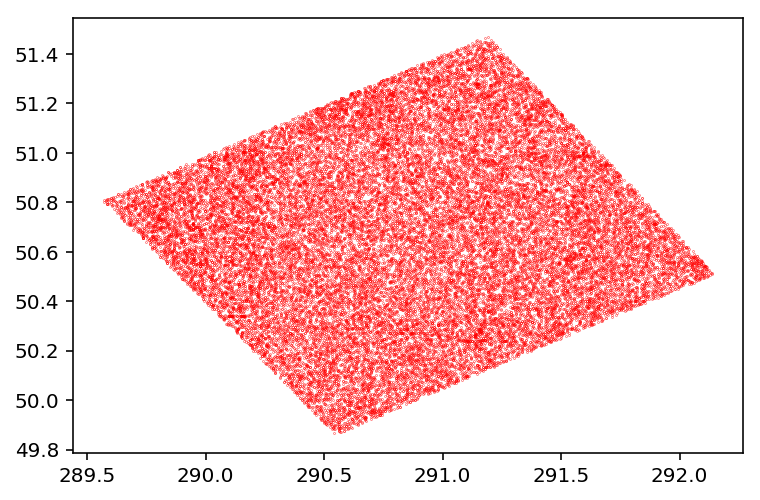

In [15]:
kic_visto_1 = kic_visto[(kic_visto.kct_sky_group_id_value==1)]
# plt.plot(kic_visto_1.kic_degree_ra,kic_visto_1.kic_dec, 'ro', markersize=0.2, fillstyle='none')
# plt.show()

In [16]:
def kic_skygroup(vector,n_sky):
    new = vector[(vector.kct_sky_group_id_value==n_sky)]
    return new

## CELULA TESTE DE COORDENADAS

In [92]:
#TESTE EM SEASON 1 SKY 1
kic_visto_1 = kic_visto[kic_visto.kct_sky_group_id_value==1]
ra,dec = kic_visto_1.kic_degree_ra,kic_visto_1.kic_dec
ra1,dec1 = np.array(ra),np.array(dec)
ra1[98],dec1[98]
caldir = '/home/usuario/Documents/Mestrado/FFIs/testeall/clean/masters/season0/'

In [93]:
caldir = '/home/usuario/Documents/Mestrado/FFIs/testeall/clean/masters/season0/'
a = fits.open(caldir+'new01.fits')
w = WCS(a[1].header,'image')

x, y = w.all_world2pix(ra1[98], dec1[98],0,ra_dec_order=True,detect_divergence=True)
x,y

(array(1052.4140981), array(118.94558952))

Teste com skygroup3

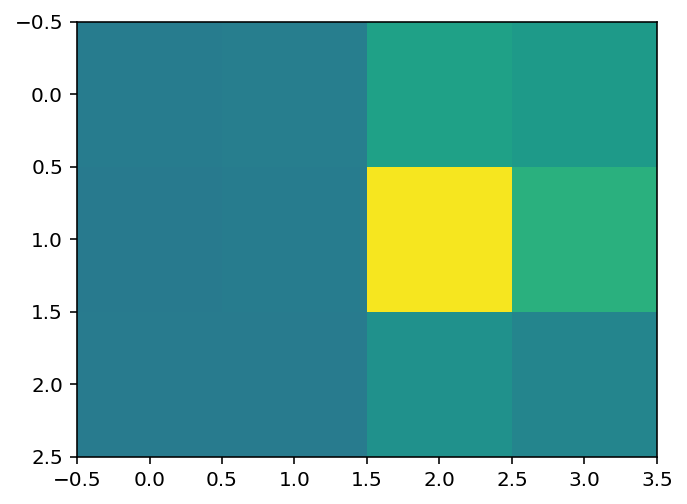

In [94]:
from astropy.nddata.utils import Cutout2D
import matplotlib.pyplot as plt
x, y = w.all_world2pix(ra1[98], dec1[98],0,ra_dec_order=True,detect_divergence=True)
Cutout_img = Cutout2D(mast,(x,y), (3,4), wcs=w)
Cutout_img
plt.imshow(Cutout_img.data,vmin=50,vmax=250)

## Teste em SEASON 3 SKY 80

In [166]:
# Teste em SEASON 3 SKY 80
kic_visto_1 = kic_visto[kic_visto.kct_sky_group_id_value==80]
ra,dec = kic_visto_1.kic_degree_ra,kic_visto_1.kic_dec
ra1,dec1 = np.array(ra),np.array(dec)
ra1[98],dec1[98]
caldir = '/home/usuario/Documents/Mestrado/FFIs/testeall/clean/masters/season3/'

a = fits.open(caldir+'new80.fits')
w = WCS(a[1].header,'image')

In [167]:
x,y = coord_min(294.43066,38.794964,ra1,dec1)
x2, y2 = w.all_world2pix(x, y,0,ra_dec_order=True)
x,y

(294.4303, 38.795155)

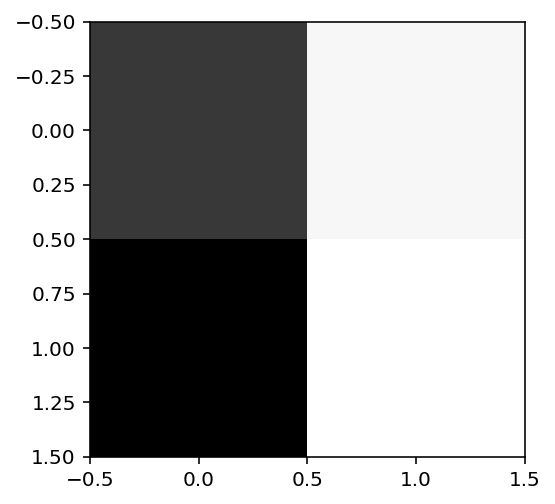

In [169]:
from astropy.nddata.utils import Cutout2D
import matplotlib.pyplot as plt

Cutout_img = Cutout2D(mast,(x2,y2), (2,2), wcs=w)
Cutout_img
plt.imshow(Cutout_img.data,cmap='Greys_r')#,vmin=0,vmax=200)

/home/usuario/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


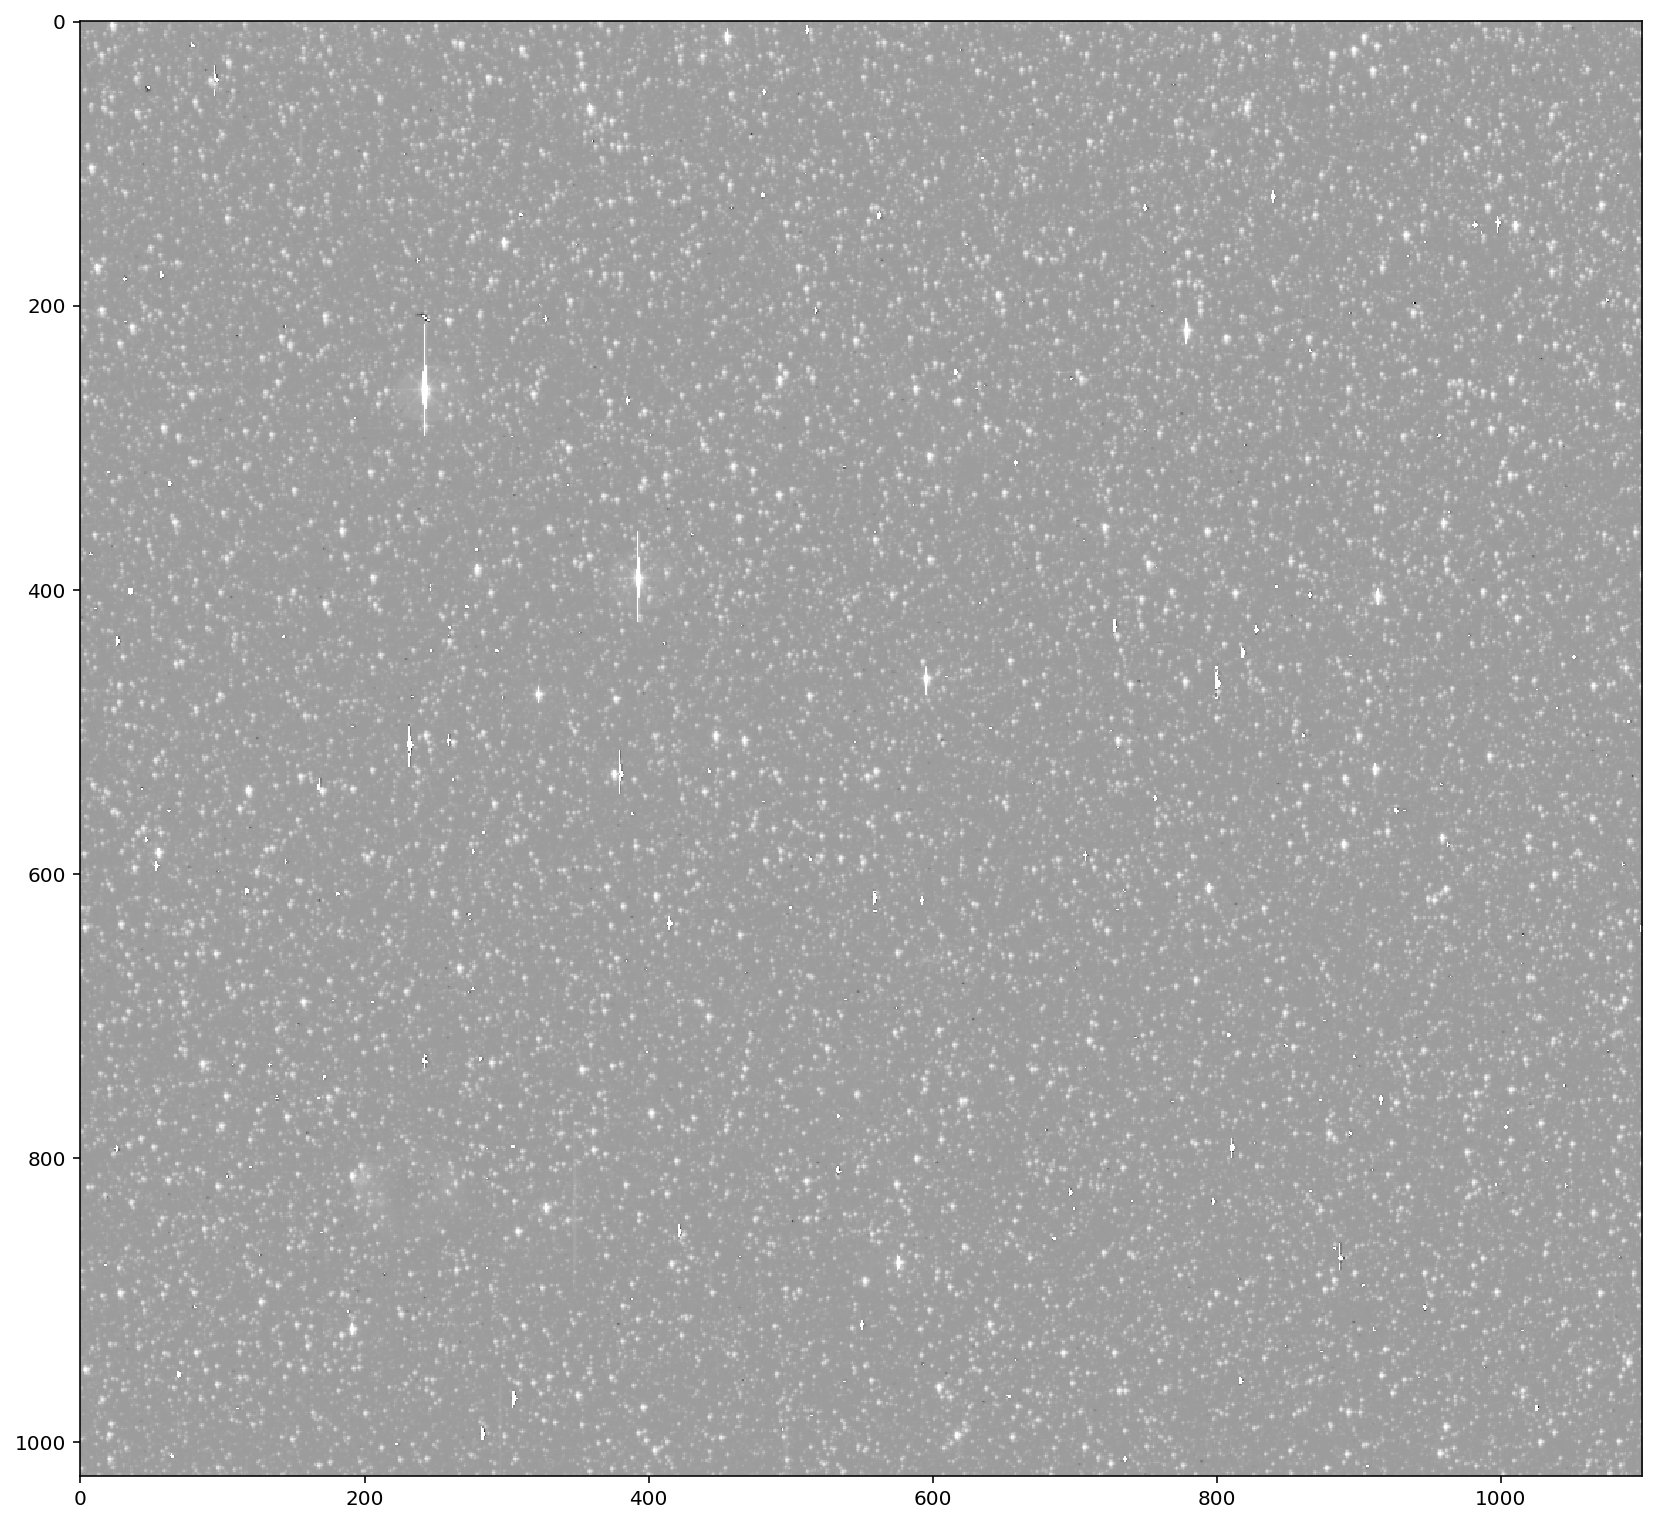

In [188]:
plt.rcParams['figure.figsize'] = (14.0, 14.0)    
plt.imshow(np.log(a[1].data),cmap='Greys_r')#,vmin=10,vmax=np.max(a[1].data))

## ver se esta rotacionando - season 2 sky 80

In [186]:
# Teste em SEASON 2 SKY 80
kic_visto_1 = kic_visto[kic_visto.kct_sky_group_id_value==80]
ra,dec = kic_visto_1.kic_degree_ra,kic_visto_1.kic_dec
ra1,dec1 = np.array(ra),np.array(dec)

caldir = '/home/usuario/Documents/Mestrado/FFIs/testeall/clean/masters/season2/'

a = fits.open(caldir+'new80.fits')
w = WCS(a[1].header,'image')

/home/usuario/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


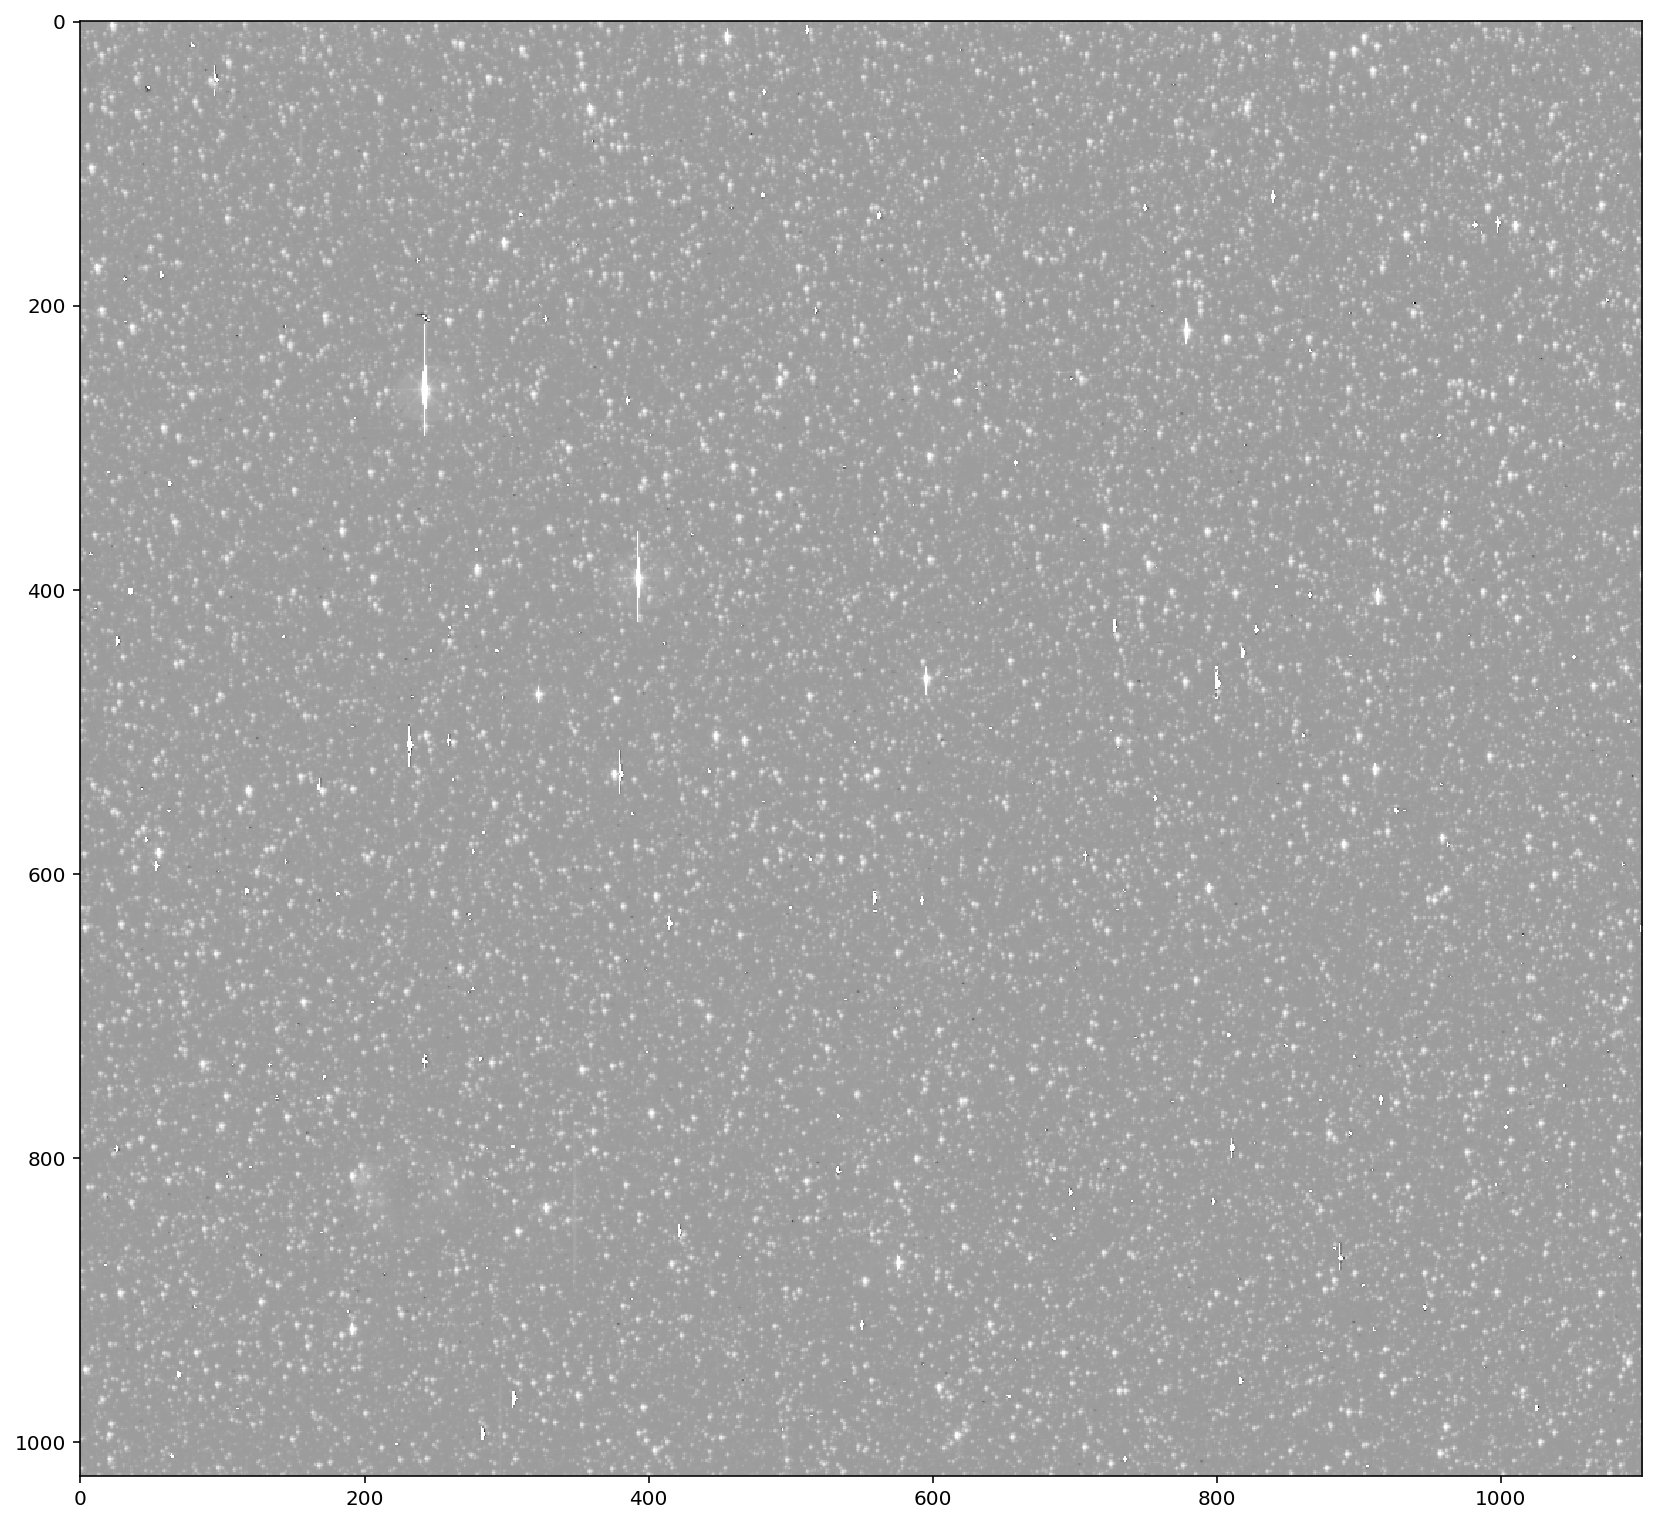

In [187]:
plt.rcParams['figure.figsize'] = (14.0, 14.0)    
plt.imshow(np.log(a[1].data),cmap='Greys_r')#,vmin=10,vmax=np.max(a[1].data))

## Season 2 sky 28

In [158]:
# TESTE SEASON 2 - sky 28
kic_visto_1 = kic_visto[kic_visto.kct_sky_group_id_value==28]
ra,dec = kic_visto_1.kic_degree_ra,kic_visto_1.kic_dec
ra1,dec1 = np.array(ra),np.array(dec)
caldir = '/home/usuario/Documents/Mestrado/FFIs/testeall/clean/masters/season2/'

In [159]:
a = fits.open(caldir+'new28.fits')
w = WCS(a[1].header,'image')

In [160]:
x,y = coord_min(283.83839,45.328001,ra1,dec1)
x2, y2 = w.all_world2pix(x, y,0,ra_dec_order=True)
x,y

(283.8385600000001, 45.327869)

No handles with labels found to put in legend.


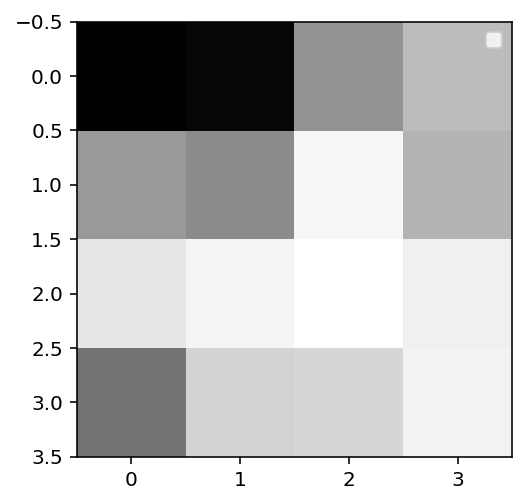

In [162]:
from astropy.nddata.utils import Cutout2D
import matplotlib.pyplot as plt

Cutout_img = Cutout2D(mast,(x2,y2), (4,4), wcs=w)
Cutout_img
plt.imshow(Cutout_img.data,cmap='Greys')#,vmin=50,vmax=500)
plt.legend()

In [35]:
# mast = fits.getdata(caldir+'new01.fits')
# w = WCS(a[1].header,'image')
# table = kic_skygroup(kic_visto,1)
# kicid = np.array(table.kic_kepler_id)
# kmag = np.array(table.kic_kepmag)
# ra = table.kic_degree_ra
# dec = table.kic_dec
# #print(len(ra),len(dec))
# x, y = w.all_world2pix(ra, dec,1,ra_dec_order=True,detect_divergence=True)
# positions = (x, y)

# rads = np.arange(2,5,.25) 

# #do the aperture photometry and find the optimal aperture
# apertures = [CircularAperture(positions, r=r) for r in rads]
# phot_table = aperture_photometry(mast, apertures, method = 'exact')
# idx = 0

# offset = np.zeros((len(rads),len(x)))
# for ii in range(0, len(x)):
#     if (x[ii] > 0) and (x[ii] < 1100) and (y[ii] > 0) and (y[ii] < 1024):
#         dist = np.sqrt((x[ii]-x)**2+(y[ii]-y)**2)
#         chk = np.where(dist < 6.)
#         if (len(chk[0]) == 1):
#             for jj in range(1, len(rads)):
#                 mg1 = 25.-2.5*np.log10(phot_table[ii][jj+3])
#                 mg0 = 25.-2.5*np.log10(phot_table[ii][jj+2])
#                 offset[jj,ii] = mg1-mg0


# prv = 1.
# opt_rad = 10.
# for ii in range(0, len(rads)):
#     chk = np.median(offset[ii,:])

#     if (np.abs(chk-prv) <= 0.001) and (rads[ii] < opt_rad):	
#         opt_rad = rads[ii]
#         print('The optimal aperture size is '+str(opt_rad)+'.')
#     if (np.abs(chk-prv) > 0.001):
#         prv = chk

# #do the aperture photometry
# apertures = CircularAperture(positions, r = opt_rad)
# phot_table = aperture_photometry(mast, apertures, method = 'exact')

# #get the background of the image
# cimg, clow, chigh = scipy.stats.sigmaclip(mast, low=2.5, high = 2.5) #do a 2.5 sigma clipping
# bkg_mean = np.median(cimg) #determine the sky value
# sig = np.std(cimg) #determine the sigma(sky)

# #convert to magnitudes
# flx = phot_table['aperture_sum']-(bkg_mean*(np.pi*opt_rad**2))
# flx_er = np.sqrt(phot_table['aperture_sum'])
# x_pix = x
# y_pix = y

# #create the magnitudes from the flux
# mag = 25.0-2.5*np.log10(flx)
# err = (2.5/np.log(10.))*(flx_er/flx)

# #write the magnitudes to a file
# output = open(caldir+'teste'+'_master.ap', 'w')
# for ii in range(0,len(phot_table['id'])):
#     if (x_pix[ii] > 0) and (x_pix[ii] < 1100) and (y_pix[ii] > 0) and (y_pix[ii] < 1024) and (np.isnan(mag[ii]) == False):
#         output.write(str(kicid[ii])+','+str(x_pix[ii])+','+str(y_pix[ii])+','+str(kmag[ii])+','+str(mag[ii])+','+str(err[ii])+'\n')
# output.close()

# #write the fluxes to a file
# output = open(caldir+str(i)+'_master.flux', 'w')
# for ii in range(0, len(phot_table['id'])):
#     if (x_pix[ii] > 0) and (x_pix[ii] < 1100) and (y_pix[ii] > 0) and (y_pix[ii] < 1024) and (np.isnan(mag[ii]) == False):
#         output.write(str(kicid[ii])+','+str(x_pix[ii])+','+str(y_pix[ii])+','+str(flx[ii])+','+str(flx_er[ii])+'\n')
# output.close()

# #write the star list to a file
# output = open(caldir+str(i)+'_starlist.txt', 'w')
# for ii in range(0, len(phot_table['id'])):
#     if (x_pix[ii] > 0) and (x_pix[ii] < 1100) and (y_pix[ii] > 0) and (y_pix[ii] < 1024) and (np.isnan(mag[ii]) == False):
#         output.write(str(kicid[ii])+','+str(x_pix[ii])+','+str(y_pix[ii])+'\n')
# output.close()

KeyboardInterrupt: 

## Managing coordinates

In [83]:
def coord_min(x,y,xs,ys):
    array=[]
    dif=[]
    closest=[]
    sigmax = np.std(xs)
    sigmay = np.std(ys)
    for i in range(len(xs)):
        if abs(x - xs[i])<sigmax/50 and abs(y - ys[i])<sigmay/50:
            #array.append([xs[i],ys[i]])
            dif.append(np.sqrt((x - xs[i])**2+(y - ys[i])**2))
            if np.min(dif) == np.sqrt((x - xs[i])**2+(y - ys[i])**2):
                closest.append([xs[i],ys[i]])
    return closest[-1]

In [34]:
from astropy.coordinates import Angle
from astropy import units as u
Angle(290.56738,u.degree).to_string(unit = u.hour, sep = ':'),Angle(49.888035,u.degree).to_string(unit = u.degree, sep = ':')

('19:22:16.1712', '49:53:16.926')

In [85]:
ra = np.array(kic_visto_1.kic_degree_ra)
dec = np.array(kic_visto_1.kic_dec)
coord_min(290.62814,49.984484,ra,dec)
coord_min(290.632,49.976809,ra,dec)

[290.63202, 49.976807]

## Already specified the season - > find the files and start

In [18]:
caldir = '/home/usuario/Documents/Mestrado/FFIs/testeall/clean/masters/season3/'
#get the positions from the star list if one is provided 
os.chdir(caldir) #changes to the raw image directory
files = [f for f in glob.glob("*.fits") if isfile(join(caldir, f))] #gets the relevant files with the proper extension
files.sort()
# os.chdir(cdedir) #changes back to the code directory

['new01.fits',
 'new02.fits',
 'new03.fits',
 'new04.fits',
 'new05.fits',
 'new06.fits',
 'new07.fits',
 'new08.fits',
 'new09.fits',
 'new10.fits',
 'new11.fits',
 'new12.fits',
 'new13.fits',
 'new14.fits',
 'new15.fits',
 'new16.fits',
 'new17.fits',
 'new18.fits',
 'new19.fits',
 'new20.fits',
 'new21.fits',
 'new22.fits',
 'new23.fits',
 'new24.fits',
 'new25.fits',
 'new26.fits',
 'new27.fits',
 'new28.fits',
 'new29.fits',
 'new30.fits',
 'new31.fits',
 'new32.fits',
 'new33.fits',
 'new34.fits',
 'new35.fits',
 'new36.fits',
 'new37.fits',
 'new38.fits',
 'new39.fits',
 'new40.fits',
 'new41.fits',
 'new42.fits',
 'new43.fits',
 'new44.fits',
 'new45.fits',
 'new46.fits',
 'new47.fits',
 'new48.fits',
 'new49.fits',
 'new50.fits',
 'new51.fits',
 'new52.fits',
 'new53.fits',
 'new54.fits',
 'new55.fits',
 'new56.fits',
 'new57.fits',
 'new58.fits',
 'new59.fits',
 'new60.fits',
 'new61.fits',
 'new62.fits',
 'new63.fits',
 'new64.fits',
 'new65.fits',
 'new66.fits',
 'new67.fi

In [19]:
for i in range(1,len(files)+1):
    print(i)
    a = fits.open(files[i-1])
    mast = fits.getdata(caldir+files[i-1])
    w = WCS(a[1].header,'image')
    table = kic_skygroup(kic_visto,i)
    kicid = np.array(table.kic_kepler_id)
    kmag = np.array(table.kic_kepmag)
    ra = table.kic_degree_ra
    dec = table.kic_dec
    #print(len(ra),len(dec))
    x, y = w.all_world2pix(ra, dec,0,ra_dec_order=True,detect_divergence=True)
    positions = (x, y)

    rads = np.arange(2,5,.25) 

    #do the aperture photometry and find the optimal aperture
    apertures = [CircularAperture(positions, r=r) for r in rads]
    phot_table = aperture_photometry(mast, apertures, method = 'exact')
    idx = 0

    offset = np.zeros((len(rads),len(x)))
    for ii in range(0, len(x)):
        if (x[ii] > 0) and (x[ii] < 1100) and (y[ii] > 0) and (y[ii] < 1024):
            dist = np.sqrt((x[ii]-x)**2+(y[ii]-y)**2)
            chk = np.where(dist < 6.)
            if (len(chk[0]) == 1):
                for jj in range(1, len(rads)):
                    mg1 = 25.-2.5*np.log10(phot_table[ii][jj+3])
                    mg0 = 25.-2.5*np.log10(phot_table[ii][jj+2])
                    offset[jj,ii] = mg1-mg0
    

    prv = 1.
    opt_rad = 10.
    for ii in range(0, len(rads)):
        chk = np.median(offset[ii,:])

        if (np.abs(chk-prv) <= 0.001) and (rads[ii] < opt_rad):	
            opt_rad = rads[ii]
            print('The optimal aperture size is '+str(opt_rad)+'.')
        if (np.abs(chk-prv) > 0.001):
            prv = chk

    #do the aperture photometry
    apertures = CircularAperture(positions, r = opt_rad)
    phot_table = aperture_photometry(mast, apertures, method = 'exact')

    #get the background of the image
    cimg, clow, chigh = scipy.stats.sigmaclip(mast, low=2.5, high = 2.5) #do a 2.5 sigma clipping
    bkg_mean = np.median(cimg) #determine the sky value
    sig = np.std(cimg) #determine the sigma(sky)

    #convert to magnitudes
    flx = phot_table['aperture_sum']-(bkg_mean*(np.pi*opt_rad**2))
    flx_er = np.sqrt(phot_table['aperture_sum'])
    x_pix = x
    y_pix = y

    #create the magnitudes from the flux
    mag = 25.0-2.5*np.log10(flx)
    err = (2.5/np.log(10.))*(flx_er/flx)

    #write the magnitudes to a file
    output = open(caldir+str(i)+'_master.ap', 'w')
    for ii in range(0,len(phot_table['id'])):
        if (x_pix[ii] > 0) and (x_pix[ii] < 1100) and (y_pix[ii] > 0) and (y_pix[ii] < 1024) and (np.isnan(mag[ii]) == False):
            output.write(str(kicid[ii])+','+str(x_pix[ii])+','+str(y_pix[ii])+','+str(kmag[ii])+','+str(mag[ii])+','+str(err[ii])+'\n')
    output.close()

    #write the fluxes to a file
    output = open(caldir+str(i)+'_master.flux', 'w')
    for ii in range(0, len(phot_table['id'])):
        if (x_pix[ii] > 0) and (x_pix[ii] < 1100) and (y_pix[ii] > 0) and (y_pix[ii] < 1024) and (np.isnan(mag[ii]) == False):
            output.write(str(kicid[ii])+','+str(x_pix[ii])+','+str(y_pix[ii])+','+str(flx[ii])+','+str(flx_er[ii])+'\n')
    output.close()

    #write the star list to a file
    output = open(caldir+str(i)+'_starlist.txt', 'w')
    for ii in range(0, len(phot_table['id'])):
        if (x_pix[ii] > 0) and (x_pix[ii] < 1100) and (y_pix[ii] > 0) and (y_pix[ii] < 1024) and (np.isnan(mag[ii]) == False):
            output.write(str(kicid[ii])+','+str(x_pix[ii])+','+str(y_pix[ii])+'\n')
    output.close()

1
The optimal aperture size is 2.25.


/home/usuario/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in log10


2


/home/usuario/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10
/home/usuario/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
/home/usuario/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


The optimal aperture size is 4.0.


/home/usuario/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in sqrt


3
The optimal aperture size is 2.25.
4
The optimal aperture size is 2.25.
5
The optimal aperture size is 2.25.
6
The optimal aperture size is 2.25.
7
8
The optimal aperture size is 2.25.
9
The optimal aperture size is 2.25.
10
The optimal aperture size is 2.25.
11
The optimal aperture size is 2.25.
12
The optimal aperture size is 2.25.
13
The optimal aperture size is 2.25.
14
The optimal aperture size is 2.25.
15
The optimal aperture size is 2.25.
16
The optimal aperture size is 2.25.
17
The optimal aperture size is 2.25.
18
The optimal aperture size is 2.25.
19
The optimal aperture size is 2.25.
20
The optimal aperture size is 2.25.
21
The optimal aperture size is 2.25.
22
The optimal aperture size is 2.25.
23
The optimal aperture size is 2.25.
24
The optimal aperture size is 2.25.
25
The optimal aperture size is 2.25.
26
The optimal aperture size is 2.25.
27
The optimal aperture size is 2.25.
28
The optimal aperture size is 2.25.
29
The optimal aperture size is 2.25.
30
The optimal a

In [ ]:
# from astropy.coordinates import SkyCoord as skc
# fil = caldir+'new1.fits'
# a = fits.open(fil)
# #print(np.shape(a[1]))
# #b[0]
# w = WCS(a[1].header,'image')
# #astropy.wcs.validate("/home/usuario/Documents/Mestrado/FFIs/allffi_cut/clean/masters/season0/new1.fits")
# x, y = w.all_world2pix(np.array(kic_visto_1.kic_degree_ra), np.array(kic_visto_1.kic_dec),0,ra_dec_order=True)
# ra_dec = skc(kic_visto_1.kic_degree_ra,kic_visto_1.kic_dec,unit=u.degree)
# positions = (x, y)
# print(positions[0])
# print('######################')

# ra,dec = w.wcs_pix2world(1071.02774722,10.41298108,0)

# print(ra,dec)
# print(ra_dec[0])

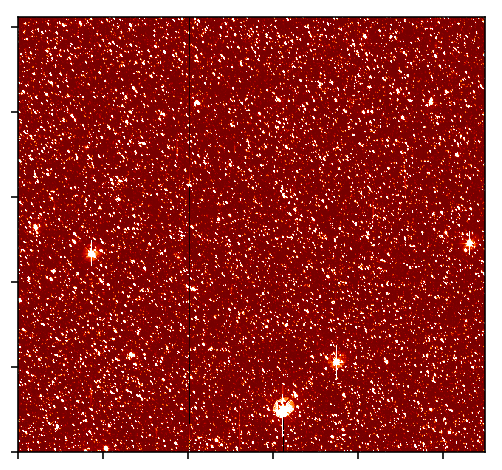

In [17]:
# Plot the image
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(a[1].data, cmap=plt.cm.gist_heat,
          origin='lower', vmin=0, vmax=500)

# Loop over lines of longitude
for lon in np.linspace(-180., 180., 13):
    grid_lon = np.repeat(lon, 100)
    grid_lat = np.linspace(-90., 90., 100)
    px, py = w.wcs_world2pix(grid_lon, grid_lat, 1)
    ax.plot(px, py, color='white', alpha=0.5)

# Loop over lines of latitude
for lat in np.linspace(-60., 60., 5):
    grid_lon = np.linspace(-180., 180., 100)
    grid_lat = np.repeat(lat, 100)
    px, py = w.wcs_world2pix(grid_lon, grid_lat, 1)
    ax.plot(px, py, color='white', alpha=0.5)

ax.set_xlim(0, a[1].data.shape[1])
ax.set_ylim(0, a[1].data.shape[0])
ax.set_xticklabels('')
ax.set_yticklabels('')
fig.savefig('wcs_extra.png', bbox_inches='tight')

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from astropy.stats import mad_std
# from photutils import (datasets, DAOStarFinder, aperture_photometry,
#                        CircularAperture)
# mast, mheader = fits.getdata(caldir+'new'+'{:02d}'.format(skygroup)+'.fits', header = True)
# hdu = mast
# image = hdu[500:700, 500:700].astype(float)
# image -= np.median(image)
# bkg_sigma = mad_std(image)
# daofind = DAOStarFinder(fwhm=4., threshold=3.*bkg_sigma)
# sources = daofind(image)
# positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
# apertures = CircularAperture(positions, r=4.)
# phot_table = aperture_photometry(mast, apertures, method = 'exact')
# brightest_source_id = phot_table['aperture_sum'].argmax()
# plt.imshow(image, cmap='gray_r', origin='lower')
# apertures.plot(color='blue', lw=1.5, alpha=0.5)
# print(phot_table[0][0])